# Clustering

Ya vimos en clase el método **BFR**, pero sabemos que a pesar de ser muy eficiente tiene muchos supuestos. Si queremos manejar Big Data pero además permitir que los clusters no tengan restricción en su forma debemos usar algo como el algoritmo **CURE**. Por esto nos concentraremos en este algoritmo.

Para asegurarnos que la forma arbitraria se pueda dar, recomiendo usar el generador de datasets de lunas (`sklearn.datasets.make_moons`). Recomiendo usar un `n_samples` pequeño durante las pruebas y después crecerlo para ver si todo funciona correctamente.


In [615]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
import numpy as np
import random
from sklearn.cluster import SpectralClustering
import itertools

In [616]:
random_seed = 42

In [617]:
random.seed(random_seed)

In [618]:
n_samples = 1000
noisy_moons = make_moons(n_samples=n_samples, noise=0.1, random_state=random_seed)
X = noisy_moons[0]  # X[n_samples, 0:2]
y = noisy_moons[1]  # y[n_samples] = clases (si quiere evaluar)

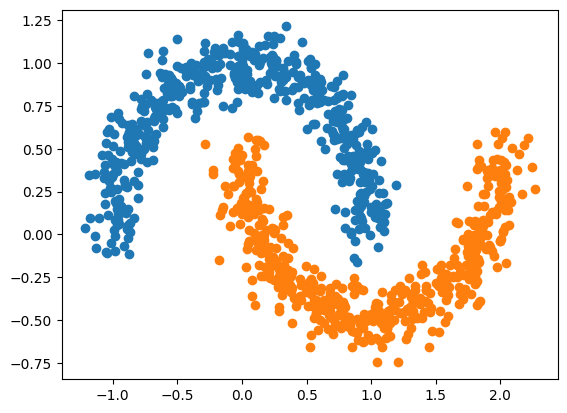

In [619]:
# Graficar por clases
cls0 = y == 0
cls1 = y == 1
plt.scatter(X[cls0, 0], X[cls0, 1])
plt.scatter(X[cls1, 0], X[cls1, 1])
plt.show()

## Pasada 1

En la primera pasada debemos hacer clusters con una muestra aleatoria para tener una partida.
Use su librería favorita para hacer dos (2) clusters con una muestra de los datos y escoja los puntos representativos de cada uno (4 estaría bien).

Al final use el parámetro `alpha = 0.2` (20%) para acercar los valores representativos al centroide.


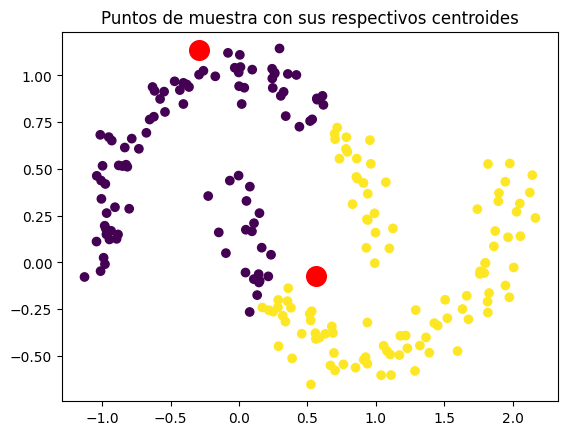

In [620]:
n_clusters = 2

sample_proportion = 0.2
sample_size = int(n_samples * sample_proportion)
sample_indices = random.sample(range(n_samples), sample_size)
X_sample = X[sample_indices]

clustering = SpectralClustering(
    n_clusters=n_clusters, assign_labels="discretize", random_state=random_seed
).fit(X_sample)
labels = clustering.labels_
X_sample_indices = np.arange(sample_size)
cluster1_points = X_sample[labels == 0]
cluster2_points = X_sample[labels == 1]
centroids = [cluster1_points.mean(axis=0), cluster2_points.mean(axis=0)]
plt.scatter(X_sample[:, 0], X_sample[:, 1], c=labels, cmap="viridis")
plt.scatter(centroids[0], centroids[1], s=200, c="red")
plt.title("Puntos de muestra con sus respectivos centroides")
plt.show()

In [621]:
def farthest_points(points, num_representatives):
    random_point_index = random.randint(0, len(points) - 1)
    farthest_points = [points[random_point_index]]
    index_to_remove = random_point_index
    points_to_consider = points
    for _ in range(1, num_representatives):
        points_to_consider = np.delete(points_to_consider, index_to_remove, 0)
        distances = np.linalg.norm(points_to_consider - farthest_points[-1], axis=1)
        index_of_farthest_point = np.argmax(distances)
        farthest_point = points_to_consider[index_of_farthest_point]
        index_to_remove = index_of_farthest_point
        farthest_points.append(farthest_point)
    return np.array(farthest_points)

In [622]:
num_representatives = 4

print(f"Número de puntos en el cluster 1: {len(cluster1_points)}")
print(f"Número de puntos en el cluster 2: {len(cluster2_points)}")

representatives_cluster1 = farthest_points(cluster1_points, num_representatives)
representatives_cluster2 = farthest_points(cluster2_points, num_representatives)

print(f"Representantes del cluster 1:\n {representatives_cluster1}")
print(f"Representantes del cluster 2:\n {representatives_cluster2}")

Número de puntos en el cluster 1: 96
Número de puntos en el cluster 2: 104
Representantes del cluster 1:
 [[ 0.14358017 -0.06293835]
 [-1.01360508  0.68250285]
 [ 0.61689559  0.84283659]
 [-1.12894072 -0.07816501]]
Representantes del cluster 2:
 [[ 1.89957445  0.37093447]
 [ 0.17055909 -0.24150851]
 [ 2.14345207  0.46681802]
 [ 0.288851   -0.44866862]]


In [623]:
def adjust_towards_centroid(representatives, centroid, factor=0.2):
    return representatives + factor * (centroid - representatives)

In [624]:
alpha = 0.2

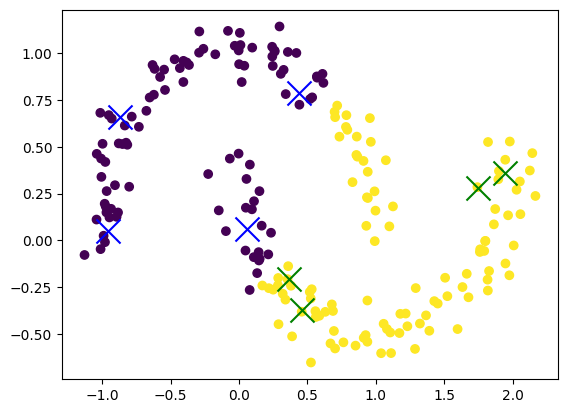

In [625]:
adjusted_representatives_cluster1 = adjust_towards_centroid(
    representatives_cluster1, centroids[0], alpha
)
adjusted_representatives_cluster2 = adjust_towards_centroid(
    representatives_cluster2, centroids[1], alpha
)

plt.scatter(X_sample[:, 0], X_sample[:, 1], c=labels, cmap="viridis")
plt.scatter(
    adjusted_representatives_cluster1[:, 0],
    adjusted_representatives_cluster1[:, 1],
    s=300,
    c="blue",
    marker="x",
)
plt.scatter(
    adjusted_representatives_cluster2[:, 0],
    adjusted_representatives_cluster2[:, 1],
    s=300,
    c="green",
    marker="x",
)
plt.show()

## Pasada 2

En la segunda pasada simplemente se concentra en que cada dato tenga su cluster asignado. Esto es sencillo, solamente tenga una lista de los valores representativos y encuentre la distancia más cercana al punto deseado. El valor representativo más cercano dictará el cluster al que pertenece.

Asigne y muestre una gráfica similar a la del comienzo para revisar cuáles fueron los clusters asignados.


In [626]:
def closest_representative(point, representatives1, representatives2):
    dists1 = np.linalg.norm(representatives1 - point, axis=1)
    dists2 = np.linalg.norm(representatives2 - point, axis=1)
    if np.min(dists1) < np.min(dists2):
        return 0
    else:
        return 1

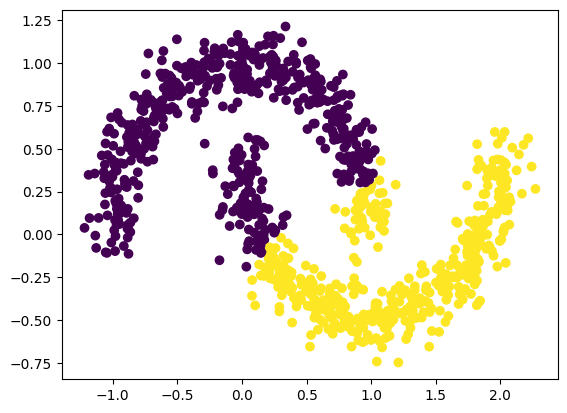

In [627]:
# Assign each point in the original dataset to the closest representative
cluster_assignments = np.array(
    [
        closest_representative(
            point, adjusted_representatives_cluster1, adjusted_representatives_cluster2
        )
        for point in X
    ]
)

# Plot the final clustering
plt.scatter(X[:, 0], X[:, 1], c=cluster_assignments, cmap="viridis")
plt.show()

# Experimentos

Ahora vamos a hacer un poco de hyperparameter tuning para hallar los mejores parámetros para la clusterización


In [628]:
from typing import Literal


def cluster(
    sample_proportion=0.2,
    num_representatives=4,
    assign_labels: Literal["kmeans", "discretize", "cluster_qr"] = "discretize",
):
    sample_size = int(n_samples * sample_proportion)
    sample_indices = random.sample(range(n_samples), sample_size)
    X_sample = X[sample_indices]
    clustering = SpectralClustering(
        n_clusters=n_clusters,
        assign_labels=assign_labels,
        random_state=random_seed,
    ).fit(X_sample)
    labels = clustering.labels_
    X_sample_indices = np.arange(sample_size)
    cluster1_sample = X_sample[labels[X_sample_indices] == 0]
    cluster2_sample = X_sample[labels[X_sample_indices] == 1]
    centroids = [cluster1_sample.mean(axis=0), cluster2_sample.mean(axis=0)]
    representatives_cluster1 = farthest_points(cluster1_points, num_representatives)
    representatives_cluster2 = farthest_points(cluster2_points, num_representatives)
    adjusted_representatives_cluster1 = adjust_towards_centroid(
        representatives_cluster1, centroids[0], alpha
    )
    adjusted_representatives_cluster2 = adjust_towards_centroid(
        representatives_cluster2, centroids[1], alpha
    )
    cluster_assignments = np.array(
        [
            closest_representative(
                point,
                adjusted_representatives_cluster1,
                adjusted_representatives_cluster2,
            )
            for point in X
        ]
    )
    accuracy = accuracy_score(y, cluster_assignments)
    return accuracy, cluster_assignments

In [629]:
hyperparameters = {
    "sample_proportion": [0.1, 0.2, 0.3, 0.4, 0.5],
    "num_representatives": [2, 4, 6, 8],
    "assign_labels": ["kmeans", "discretize", "cluster_qr"],
}

best_accuracy = 0
best_hyperparameters = {}
best_cluster_assignments = np.empty(0)

# Convert the hyperparameters dictionary into a list of dictionaries
hyperparameter_values = list(hyperparameters.values())
hyperparameter_names = list(hyperparameters.keys())
hyperparameter_combinations = [
    dict(zip(hyperparameter_names, values))
    for values in itertools.product(*hyperparameter_values)
]

for hyperparameter_combination in hyperparameter_combinations:
    accuracy, cluster_assignments = cluster(**hyperparameter_combination)
    if accuracy > best_accuracy:
        best_cluster_assignments = cluster_assignments
        best_accuracy = accuracy
        best_hyperparameters = hyperparameter_combination

print(f"Best accuracy: {best_accuracy}")
print(f"Best hyperparameters: {best_hyperparameters}")

Best accuracy: 0.979
Best hyperparameters: {'sample_proportion': 0.1, 'num_representatives': 4, 'assign_labels': 'cluster_qr'}


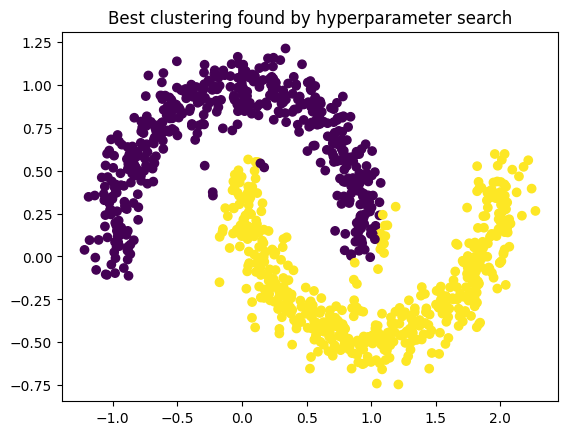

In [630]:
plt.scatter(X[:, 0], X[:, 1], c=best_cluster_assignments, cmap="viridis")
plt.title("Best clustering found by hyperparameter search")
plt.show()